# Image Analysis for Instagram Photos

This notebook analyzes downloaded Instagram images to extract:
1. **Luminosity** - Grayscale intensity values
2. **Saturation** - Median of S channel in HSV color space
3. **Predominant Color** - Using K-means clustering and histograms

## Setup and Imports

In [1]:
from datetime import datetime
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
from sklearn.cluster import KMeans
from collections import Counter
import seaborn as sns

# Set style for better visualizations
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


## Configuration

In [22]:
# Directory containing downloaded images
# IMAGE_DIR = "images"
IMAGE_DIR = "C:/Users/arthu/Downloads/img_dataset"

# Number of clusters for K-means (for predominant color detection)
N_COLORS = 5

# Image extensions to process
VALID_EXTENSIONS = (".jpg", ".jpeg", ".png", ".webp")

print(f"Image directory: {IMAGE_DIR}")
print(f"Number of color clusters: {N_COLORS}")

Image directory: C:/Users/arthu/Downloads/img_dataset
Number of color clusters: 5


## Helper Functions

In [23]:
def load_image(image_path):
    """
    Load an image from file.

    Args:
        image_path: Path to the image file

    Returns:
        Image in BGR format (OpenCV default)
    """
    img = cv2.imread(str(image_path))
    if img is None:
        raise ValueError(f"Failed to load image: {image_path}")
    return img


def calculate_luminosity(image):
    """
    Calculate luminosity statistics of an image.

    Args:
        image: BGR image

    Returns:
        Dictionary with luminosity statistics
    """
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    return {
        "mean_luminosity": float(np.mean(gray)),
        "median_luminosity": float(np.median(gray)),
        "std_luminosity": float(np.std(gray)),
        "min_luminosity": int(np.min(gray)),
        "max_luminosity": int(np.max(gray)),
    }


def calculate_saturation(image):
    """
    Calculate saturation statistics using HSV color space.

    Args:
        image: BGR image

    Returns:
        Dictionary with saturation statistics
    """
    # Convert to HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Extract saturation channel (S)
    saturation = hsv[:, :, 1]

    return {
        "median_saturation": float(np.median(saturation)),
        "mean_saturation": float(np.mean(saturation)),
        "std_saturation": float(np.std(saturation)),
        "min_saturation": int(np.min(saturation)),
        "max_saturation": int(np.max(saturation)),
    }


def get_predominant_colors(image, n_colors=5):
    """
    Get predominant colors using K-means clustering.

    Args:
        image: BGR image
        n_colors: Number of predominant colors to extract

    Returns:
        Dictionary with predominant colors and their percentages
    """
    # Convert BGR to RGB for better color representation
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Reshape image to be a list of pixels
    pixels = rgb_image.reshape(-1, 3)

    # Apply K-means clustering
    kmeans = KMeans(n_clusters=n_colors, random_state=42, n_init=10)
    kmeans.fit(pixels)

    # Get cluster centers (colors) and labels
    colors = kmeans.cluster_centers_.astype(int)
    labels = kmeans.labels_

    # Count pixels in each cluster
    label_counts = Counter(labels)
    total_pixels = len(pixels)

    # Calculate percentages and sort by frequency
    color_info = []
    for i in range(n_colors):
        percentage = (label_counts[i] / total_pixels) * 100
        color_info.append({"color_rgb": tuple(colors[i]), "percentage": percentage})

    # Sort by percentage (descending)
    color_info.sort(key=lambda x: x["percentage"], reverse=True)

    return {
        "predominant_color": color_info[0]["color_rgb"],
        "predominant_color_percentage": color_info[0]["percentage"],
        "all_colors": color_info,
    }


def get_color_category(rgb_color):
    """
    Classify RGB color into a categorical color name.

    Args:
        rgb_color: Tuple of (R, G, B) values (0-255)

    Returns:
        String representing the color category
    """
    r, g, b = rgb_color

    # Convert to HSV for better color classification
    # Normalize to 0-1 range
    r_norm, g_norm, b_norm = r / 255.0, g / 255.0, b / 255.0

    max_val = max(r_norm, g_norm, b_norm)
    min_val = min(r_norm, g_norm, b_norm)
    diff = max_val - min_val

    # Calculate saturation and value
    saturation = 0 if max_val == 0 else diff / max_val
    value = max_val

    # Calculate hue
    if diff == 0:
        hue = 0
    elif max_val == r_norm:
        hue = 60 * (((g_norm - b_norm) / diff) % 6)
    elif max_val == g_norm:
        hue = 60 * (((b_norm - r_norm) / diff) + 2)
    else:
        hue = 60 * (((r_norm - g_norm) / diff) + 4)

    # Classify achromatic colors (low saturation or low value)
    if saturation < 0.15:
        if value < 0.2:
            return "Black"
        elif value > 0.8:
            return "White"
        else:
            return "Gray"

    # Classify chromatic colors by hue
    if hue < 15 or hue >= 345:
        return "Red"
    elif 15 <= hue < 45:
        return "Orange"
    elif 45 <= hue < 75:
        return "Yellow"
    elif 75 <= hue < 165:
        return "Green"
    elif 165 <= hue < 195:
        return "Cyan"
    elif 195 <= hue < 255:
        return "Blue"
    elif 255 <= hue < 285:
        return "Purple"
    elif 285 <= hue < 315:
        return "Magenta"
    else:  # 315 <= hue < 345
        return "Pink"


def get_color_temperature(rgb_color):
    """
    Determine if a color is warm or cool.

    Args:
        rgb_color: Tuple of (R, G, B) values (0-255)

    Returns:
        String: "warm" or "cool"
    """
    r, g, b = rgb_color

    # Calculate color temperature using a weighted approach
    # Warm colors have more red/yellow, cool colors have more blue/cyan
    warm_score = (r * 1.0 + g * 0.5) / 2
    cool_score = (b * 1.0 + g * 0.3) / 2

    return "warm" if warm_score > cool_score else "cool"


def extract_metadata(image_path: Path):
    """
    Extract engagement metadata from image filename.

    Args:
        image_path: Path object for the image

    Returns:
        Dictionary with metadata (name, likes, comments, date)
        or None if parsing fails
    """
    try:
        # Remove (1), (2), etc. suffixes if present
        stem = image_path.stem
        stem = stem.split("(")[0].rstrip()

        parts = stem.split("_")

        if len(parts) < 4:
            print(
                f"Warning: Filename '{image_path.name}' doesn't match expected format"
            )
            return None

        return {
            "name": parts[0],
            "likes": int(parts[1]),
            "comments": int(parts[2]),
            "date": datetime.strptime(parts[3], "%d%m%Y"),
        }
    except (ValueError, IndexError) as e:
        print(f"Warning: Could not parse metadata from '{image_path.name}': {e}")
        return None


def analyze_image(image_path, n_colors=5):
    """
    Perform complete analysis on an image.

    Args:
        image_path: Path to the image file
        n_colors: Number of predominant colors to extract

    Returns:
        Dictionary with all analysis results
    """
    try:
        # Load image
        image = load_image(image_path)

        # Get image info
        height, width, channels = image.shape

        # Perform analysis
        luminosity = calculate_luminosity(image)
        saturation = calculate_saturation(image)
        colors = get_predominant_colors(image, n_colors)

        # Extract engagement metadata
        metadata = extract_metadata(Path(image_path))

        # Get color category and temperature
        predominant_rgb = colors["predominant_color"]
        color_category = get_color_category(predominant_rgb)
        color_temperature = get_color_temperature(predominant_rgb)

        # Combine results
        result = {
            "filename": os.path.basename(image_path),
            "width": width,
            "height": height,
            "channels": channels,
            **luminosity,
            **saturation,
            **colors,
            "color_category": color_category,
            "color_temperature": color_temperature,
        }

        # Add metadata if successfully parsed
        if metadata:
            result.update(metadata)

        return result

    except Exception as e:
        print(f"Error analyzing {image_path}: {e}")
        return None


print("Helper functions defined successfully!")

Helper functions defined successfully!


## Load and Analyze Images

In [24]:
# Get list of image files
image_dir = Path(IMAGE_DIR)

if not image_dir.exists():
    print(f"Error: Directory '{IMAGE_DIR}' not found.")
    print("Please run photo_downloader.py first to download images.")
else:
    image_files = [
        f for f in image_dir.iterdir() if f.suffix.lower() in VALID_EXTENSIONS
    ]

    # Remove duplicate images (keep only most recent version)
    # Group by base filename (without (1), (2), etc.)
    from collections import defaultdict

    file_groups = defaultdict(list)
    for f in image_files:
        # Extract base name without (N) suffix
        base_name = f.stem.split("(")[0].rstrip()
        file_groups[base_name].append(f)

    # For each group, keep the file with highest engagement or most recent
    unique_files = []
    duplicates_removed = 0

    for base_name, files in file_groups.items():
        if len(files) == 1:
            unique_files.append(files[0])
        else:
            # Multiple versions exist, select the best one
            # Try to parse engagement metrics and keep the highest
            best_file = files[0]
            best_engagement = -1

            for f in files:
                try:
                    parts = f.stem.split("(")[0].rstrip().split("_")
                    if len(parts) >= 3:
                        likes = int(parts[1])
                        comments = int(parts[2])
                        engagement = likes + comments
                        if engagement > best_engagement:
                            best_engagement = engagement
                            best_file = f
                except:
                    pass

            unique_files.append(best_file)
            duplicates_removed += len(files) - 1

    image_files = unique_files

    print(f"Found {len(image_files)} unique images to analyze.")
    if duplicates_removed > 0:
        print(
            f"Removed {duplicates_removed} duplicate images (kept most recent versions)."
        )

Found 401 unique images to analyze.
Removed 181 duplicate images (kept most recent versions).


In [25]:
# Analyze all images
results = []

for i, image_path in enumerate(image_files, 1):
    print(f"Analyzing image {i}/{len(image_files)}: {image_path.name}")
    result = analyze_image(image_path, n_colors=N_COLORS)
    if result:
        results.append(result)

print(f"\nSuccessfully analyzed {len(results)} images.")

Analyzing image 1/401: Bershka_10200_38_07122024(1).png
Analyzing image 2/401: Bershka_10200_45_22102024(1).png
Analyzing image 3/401: Bershka_10200_61_09082024.png
Analyzing image 4/401: Bershka_107000_551_17032024(1).png
Analyzing image 5/401: Bershka_11100_41_16092024(1).png
Analyzing image 6/401: Bershka_11400_46_08112024(1).png
Analyzing image 7/401: Bershka_12500_72_23082024(1).png
Analyzing image 8/401: Bershka_12600_46_08102024(1).png
Analyzing image 9/401: Bershka_12600_71_02102024(1).png
Analyzing image 10/401: Bershka_12700_57_16012024.png
Analyzing image 11/401: Bershka_14200_60_14102024(1).png
Analyzing image 12/401: Bershka_14400_36_26082024(1).png
Analyzing image 13/401: Bershka_14600_42_19052024(1).png
Analyzing image 14/401: Bershka_15000_114_01032024.png
Analyzing image 15/401: Bershka_15200_58_14112024(1).png
Analyzing image 16/401: Bershka_15500_40_30092024(1).png
Analyzing image 17/401: Bershka_16400_57_03082024(1).png
Analyzing image 18/401: Bershka_16700_64_02082

## Create Results DataFrame

In [26]:
# Create DataFrame with basic metrics
df = pd.DataFrame(results)

# Add engagement total metric
if "likes" in df.columns and "comments" in df.columns:
    df["engagement_total"] = df["likes"] + df["comments"]

# Display basic info
print(f"Total images analyzed: {len(df)}")
print(f"\nColumns: {list(df.columns)}")

# Check if engagement metrics were successfully extracted
has_engagement = "likes" in df.columns and "comments" in df.columns

# Display first few rows
if has_engagement:
    display_columns = [
        "filename",
        "likes",
        "comments",
        "engagement_total",
        "mean_luminosity",
        "median_saturation",
        "color_category",
        "color_temperature",
    ]
else:
    display_columns = [
        "filename",
        "width",
        "height",
        "mean_luminosity",
        "median_saturation",
        "predominant_color_percentage",
    ]

df[display_columns].head()

Total images analyzed: 401

Columns: ['filename', 'width', 'height', 'channels', 'mean_luminosity', 'median_luminosity', 'std_luminosity', 'min_luminosity', 'max_luminosity', 'median_saturation', 'mean_saturation', 'std_saturation', 'min_saturation', 'max_saturation', 'predominant_color', 'predominant_color_percentage', 'all_colors', 'color_category', 'color_temperature', 'name', 'likes', 'comments', 'date', 'engagement_total']


,filename,likes,comments,engagement_total,mean_luminosity,median_saturation,color_category,color_temperature
0,Bershka_10200_38_07122024(1).png,10200.0,38.0,10238.0,132.288676,5.0,Gray,warm
1,Bershka_10200_45_22102024(1).png,10200.0,45.0,10245.0,130.968775,8.0,Gray,warm
2,Bershka_10200_61_09082024.png,10200.0,61.0,10261.0,199.662403,10.0,White,warm
3,Bershka_107000_551_17032024(1).png,107000.0,551.0,107551.0,148.020645,59.0,White,warm
4,Bershka_11100_41_16092024(1).png,11100.0,41.0,11141.0,101.460755,13.0,Gray,warm


## Statistical Summary

In [27]:
# Display statistics
stats_columns = [
    "mean_luminosity",
    "median_luminosity",
    "median_saturation",
    "mean_saturation",
]
print("Statistical Summary:")
df[stats_columns].describe()

Statistical Summary:


,mean_luminosity,median_luminosity,median_saturation,mean_saturation
count,401.000000,401.000000,401.000000,401.000000
mean,132.219538,136.693267,44.748130,54.552602
std,41.158865,57.565816,39.606741,34.608537
min,18.174918,2.000000,0.000000,0.014873
25%,106.254005,99.000000,14.000000,31.411312
50%,130.347613,134.000000,35.000000,47.586544
75%,162.574144,182.000000,65.000000,72.417948
max,237.604860,255.000000,249.000000,198.075159


## Visualizations

### Luminosity Distribution

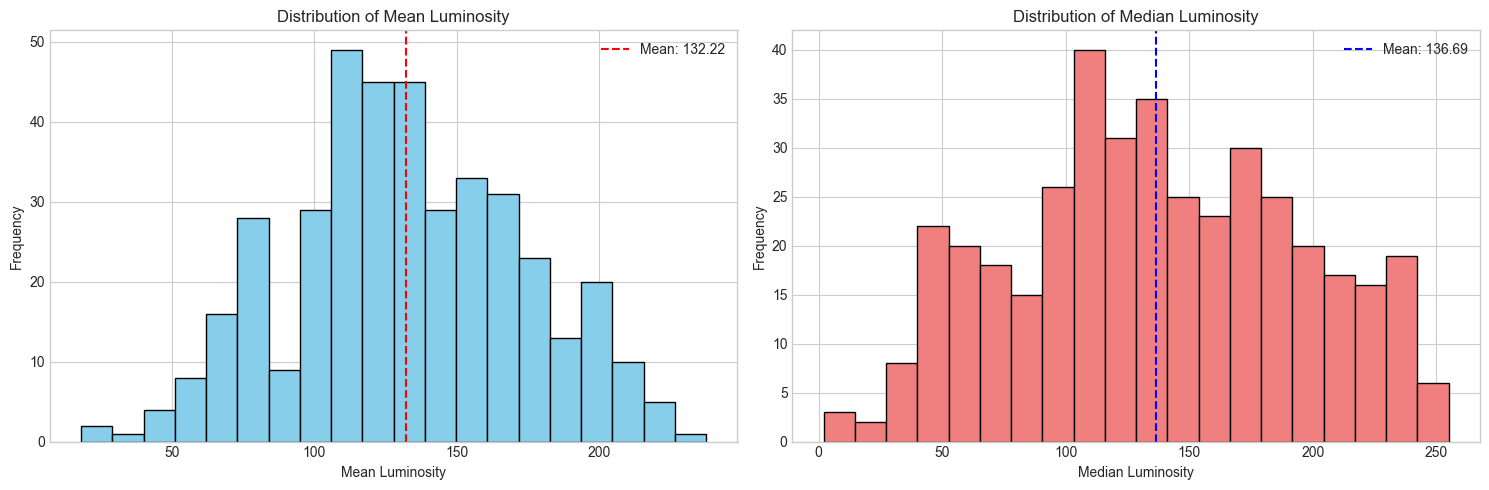

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Mean luminosity histogram
axes[0].hist(df["mean_luminosity"], bins=20, color="skyblue", edgecolor="black")
axes[0].set_xlabel("Mean Luminosity")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Distribution of Mean Luminosity")
axes[0].axvline(
    df["mean_luminosity"].mean(),
    color="red",
    linestyle="--",
    label=f"Mean: {df['mean_luminosity'].mean():.2f}",
)
axes[0].legend()

# Median luminosity histogram
axes[1].hist(df["median_luminosity"], bins=20, color="lightcoral", edgecolor="black")
axes[1].set_xlabel("Median Luminosity")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Distribution of Median Luminosity")
axes[1].axvline(
    df["median_luminosity"].mean(),
    color="blue",
    linestyle="--",
    label=f"Mean: {df['median_luminosity'].mean():.2f}",
)
axes[1].legend()

plt.tight_layout()
plt.show()

### Saturation Distribution

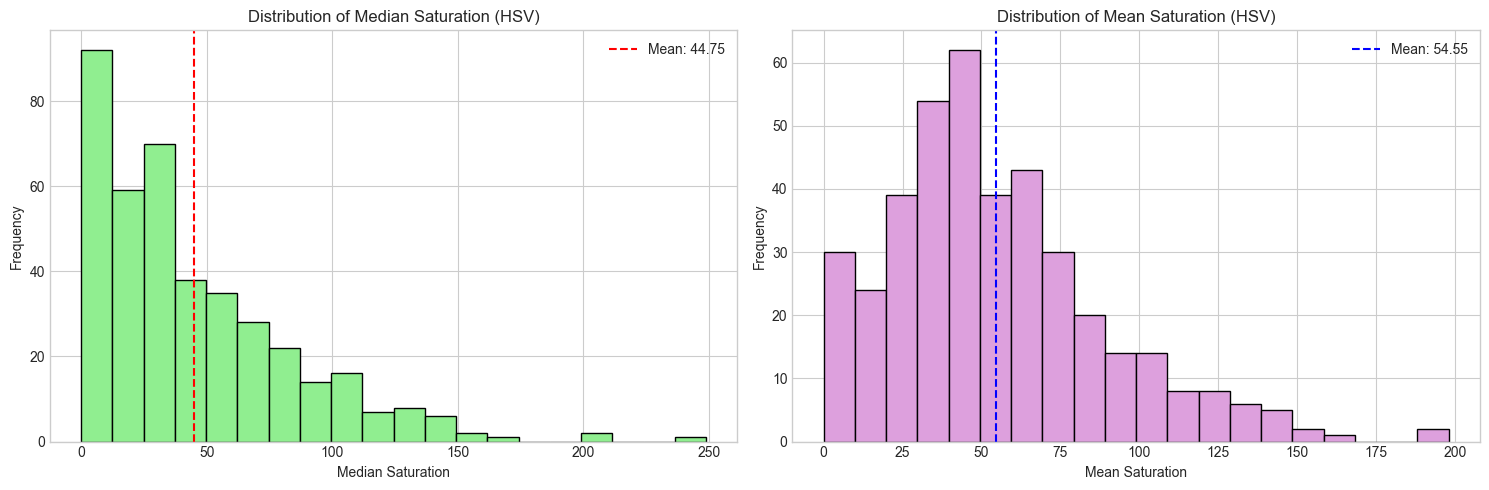

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Median saturation histogram
axes[0].hist(df["median_saturation"], bins=20, color="lightgreen", edgecolor="black")
axes[0].set_xlabel("Median Saturation")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Distribution of Median Saturation (HSV)")
axes[0].axvline(
    df["median_saturation"].mean(),
    color="red",
    linestyle="--",
    label=f"Mean: {df['median_saturation'].mean():.2f}",
)
axes[0].legend()

# Mean saturation histogram
axes[1].hist(df["mean_saturation"], bins=20, color="plum", edgecolor="black")
axes[1].set_xlabel("Mean Saturation")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Distribution of Mean Saturation (HSV)")
axes[1].axvline(
    df["mean_saturation"].mean(),
    color="blue",
    linestyle="--",
    label=f"Mean: {df['mean_saturation'].mean():.2f}",
)
axes[1].legend()

plt.tight_layout()
plt.show()

### Luminosity vs Saturation Scatter Plot

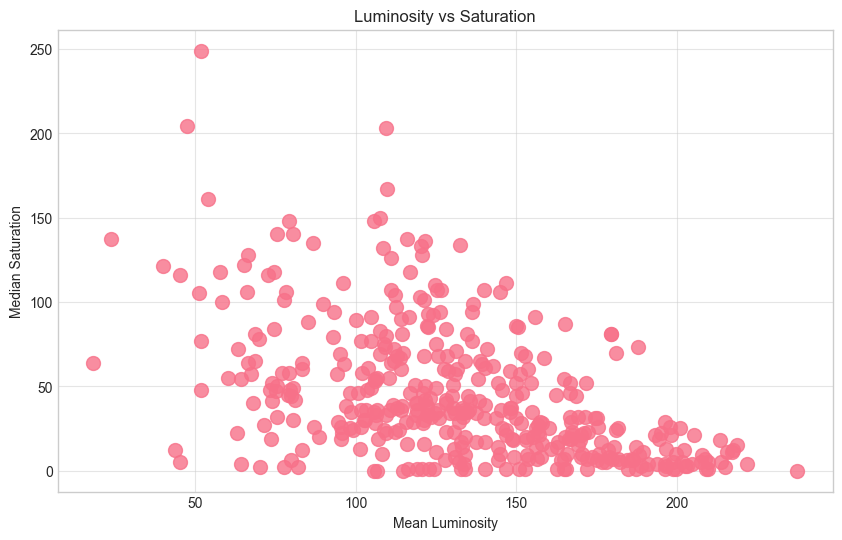

In [30]:
plt.figure(figsize=(10, 6))
plt.scatter(df["mean_luminosity"], df["median_saturation"], alpha=0.8, s=100)
plt.xlabel("Mean Luminosity")
plt.ylabel("Median Saturation")
plt.title("Luminosity vs Saturation")
plt.grid(True, alpha=0.5)
plt.show()

### Predominant Colors Visualization

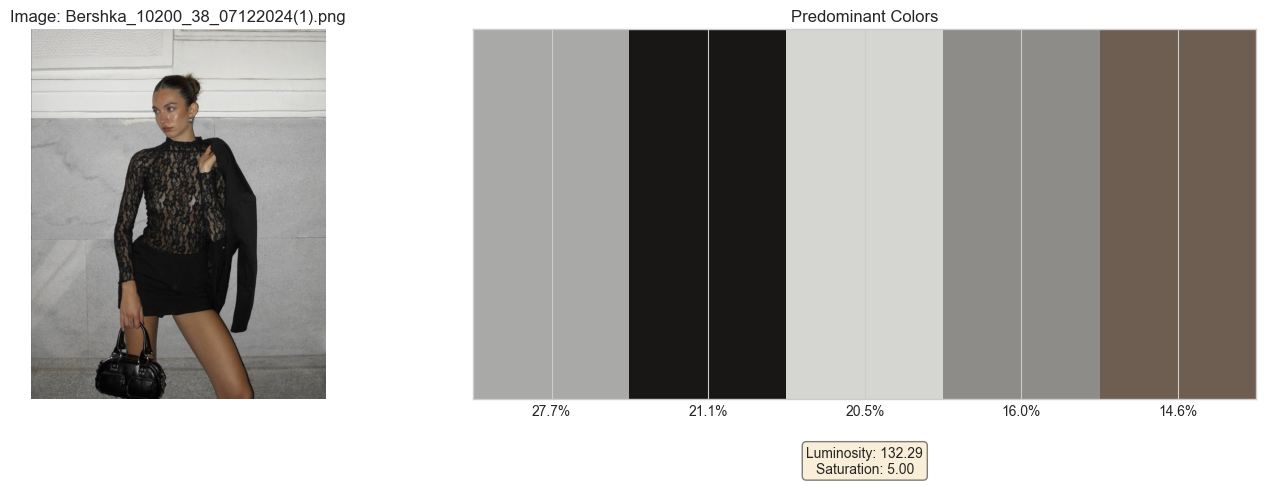

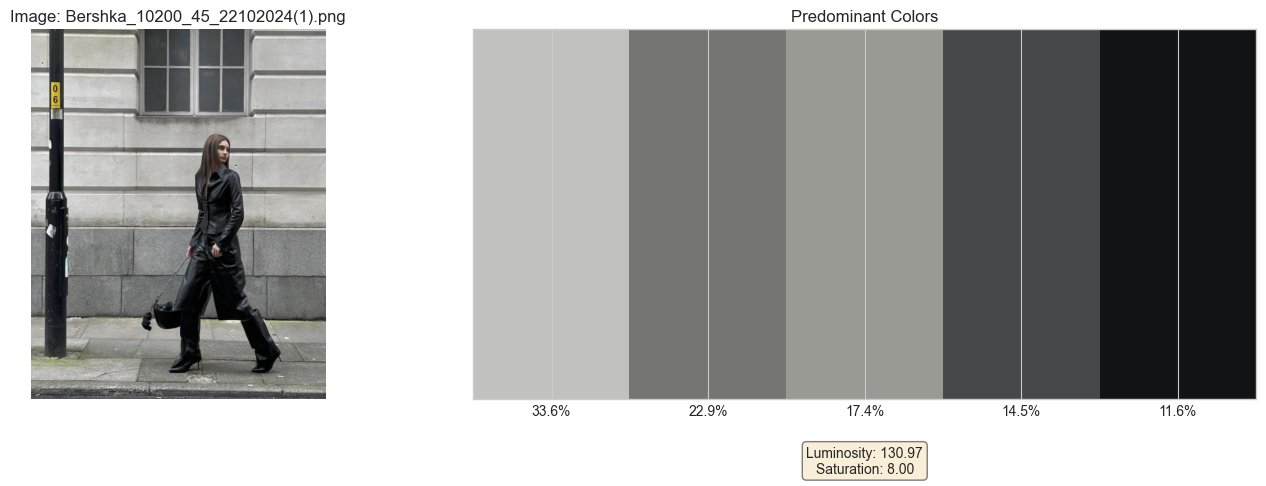

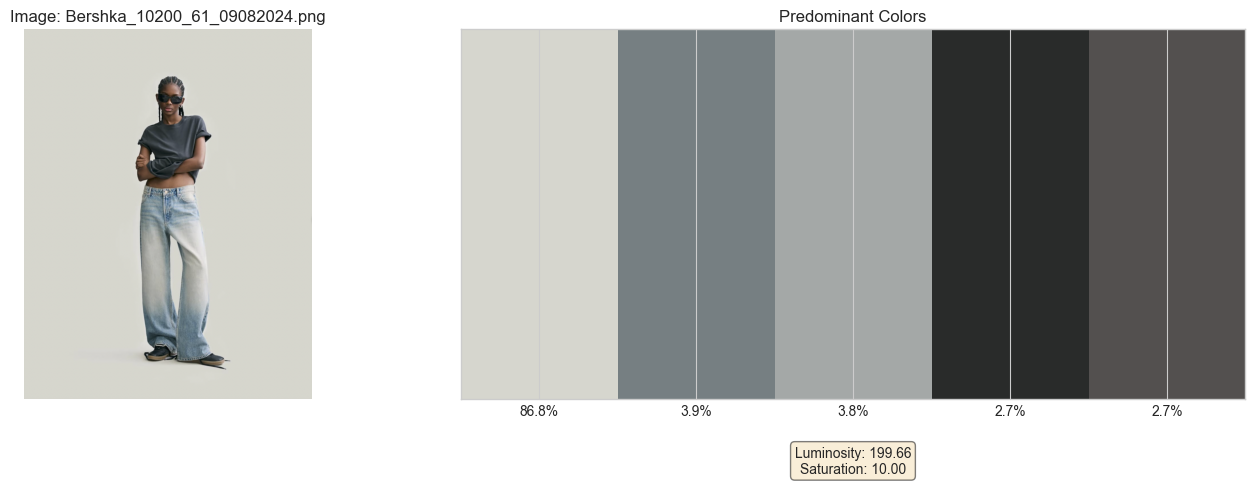

In [31]:
def plot_image_with_colors(image_path, result, n_colors=5):
    """
    Plot an image alongside its predominant colors.

    Args:
        image_path: Path to the image file
        result: Analysis result dictionary
        n_colors: Number of colors to display
    """
    # Load and convert image
    img_bgr = load_image(image_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Display image
    axes[0].imshow(img_rgb)
    axes[0].set_title(f"Image: {result['filename']}")
    axes[0].axis("off")

    # Display color palette
    colors_info = result["all_colors"][:n_colors]
    colors = [c["color_rgb"] for c in colors_info]
    percentages = [c["percentage"] for c in colors_info]

    # Create color bars
    color_array = np.array(colors).reshape(1, -1, 3) / 255.0
    axes[1].imshow(color_array, aspect="auto")
    axes[1].set_title("Predominant Colors")
    axes[1].set_yticks([])
    axes[1].set_xticks(range(len(colors)))
    axes[1].set_xticklabels([f"{p:.1f}%" for p in percentages])

    # Add stats
    stats_text = f"Luminosity: {result['mean_luminosity']:.2f}\nSaturation: {result['median_saturation']:.2f}"
    axes[1].text(
        0.5,
        -0.2,
        stats_text,
        transform=axes[1].transAxes,
        ha="center",
        fontsize=10,
        bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5),
    )

    plt.tight_layout()
    plt.show()


# Display first few images with their predominant colors
n_samples = min(3, len(results))
for i in range(n_samples):
    image_path = image_dir / results[i]["filename"]
    plot_image_with_colors(image_path, results[i], n_colors=N_COLORS)

## Save Results to CSV

In [32]:
# Prepare DataFrame for export (exclude complex nested data)
export_df = df.drop(columns=["all_colors"], errors="ignore").copy()

# Convert predominant_color tuple to string
export_df["predominant_color"] = export_df["predominant_color"].apply(str)

# Save to CSV
output_file = "image_analysis_results_full.csv"
export_df.to_csv(output_file, index=False)
print(f"Results saved to {output_file}")

Results saved to image_analysis_results_full.csv


## Summary Statistics

In [33]:
print("=" * 60)
print("IMAGE ANALYSIS SUMMARY")
print("=" * 60)
print(f"\nTotal images analyzed: {len(df)}")
print(f"\nAverage Luminosity: {df['mean_luminosity'].mean():.2f}")
print(f"Average Saturation: {df['median_saturation'].mean():.2f}")
print(f"\nBrightest image: {df.loc[df['mean_luminosity'].idxmax(), 'filename']}")
print(f"Darkest image: {df.loc[df['mean_luminosity'].idxmin(), 'filename']}")
print(f"\nMost saturated image: {df.loc[df['median_saturation'].idxmax(), 'filename']}")
print(f"Least saturated image: {df.loc[df['median_saturation'].idxmin(), 'filename']}")
print("\n" + "=" * 60)

IMAGE ANALYSIS SUMMARY

Total images analyzed: 401

Average Luminosity: 132.22
Average Saturation: 44.75

Brightest image: Victoriassecret_13200_35_11022024(1).png
Darkest image: Victoriassecret_312000_359_22102024.png

Most saturated image: hm_8005_144_27092024.png
Least saturated image: Mango_2695_6223022024.png



## Correlation Analysis

Now we'll analyze the relationship between image attributes and engagement metrics.

### Prepare Data for Correlation

In [34]:
# Import scipy for statistical tests
from scipy import stats

# Check if we have engagement data
if "likes" not in df.columns or "comments" not in df.columns:
    print("⚠ Warning: No engagement data found in the dataset.")
    print(
        "Make sure your image filenames follow the pattern: name_likes_comments_date.ext"
    )
else:
    # Select continuous variables for correlation analysis
    continuous_vars = [
        "mean_luminosity",
        "median_luminosity",
        "std_luminosity",
        "median_saturation",
        "mean_saturation",
        "std_saturation",
        "predominant_color_percentage",
    ]

    engagement_vars = ["likes", "comments", "engagement_total"]

    # Create subset for correlation analysis
    corr_data = df[engagement_vars + continuous_vars].copy()

    # Check for missing values
    missing = corr_data.isnull().sum()
    if missing.any():
        print("Missing values found:")
        print(missing[missing > 0])
        print("\nDropping rows with missing values...")
        corr_data = corr_data.dropna()

    print(
        f"Correlation analysis dataset: {corr_data.shape[0]} samples, {corr_data.shape[1]} variables"
    )
    print(f"\nEngagement metrics summary:")
    print(corr_data[engagement_vars].describe())

Missing values found:
likes               11
comments            11
engagement_total    11
dtype: int64

Dropping rows with missing values...
Correlation analysis dataset: 390 samples, 10 variables

Engagement metrics summary:
              likes      comments  engagement_total
count  3.900000e+02    390.000000      3.900000e+02
mean   4.137456e+04    287.576923      4.166214e+04
std    9.135266e+04    696.556538      9.155893e+04
min    1.290000e+03      9.000000      1.468000e+03
25%    7.023750e+03     53.000000      7.048000e+03
50%    1.640000e+04     91.500000      1.658300e+04
75%    4.047500e+04    262.000000      4.082050e+04
max    1.290000e+06  11600.000000      1.291118e+06


### Pearson Correlation Analysis (Linear Relationships)

In [35]:
if "likes" in df.columns:
    # Calculate Pearson correlation matrix
    pearson_corr = corr_data.corr(method="pearson")

    # Extract correlations with engagement metrics
    likes_corr = pearson_corr["likes"][continuous_vars].sort_values(ascending=False)
    comments_corr = pearson_corr["comments"][continuous_vars].sort_values(
        ascending=False
    )
    total_corr = pearson_corr["engagement_total"][continuous_vars].sort_values(
        ascending=False
    )

    print("=" * 70)
    print("PEARSON CORRELATION (Linear Relationships)")
    print("=" * 70)

    print("\n📊 Correlation with LIKES:")
    print("-" * 70)
    for var, corr in likes_corr.items():
        # Calculate p-value
        _, p_value = stats.pearsonr(corr_data["likes"], corr_data[var])
        sig = (
            "***"
            if p_value < 0.001
            else "**"
            if p_value < 0.01
            else "*"
            if p_value < 0.05
            else ""
        )
        strength = (
            "STRONG" if abs(corr) >= 0.5 else "MODERATE" if abs(corr) >= 0.3 else "weak"
        )
        print(f"  {var:30s}: {corr:+.3f} {sig:3s} [{strength}] (p={p_value:.4f})")

    print("\n💬 Correlation with COMMENTS:")
    print("-" * 70)
    for var, corr in comments_corr.items():
        _, p_value = stats.pearsonr(corr_data["comments"], corr_data[var])
        sig = (
            "***"
            if p_value < 0.001
            else "**"
            if p_value < 0.01
            else "*"
            if p_value < 0.05
            else ""
        )
        strength = (
            "STRONG" if abs(corr) >= 0.5 else "MODERATE" if abs(corr) >= 0.3 else "weak"
        )
        print(f"  {var:30s}: {corr:+.3f} {sig:3s} [{strength}] (p={p_value:.4f})")

    print("\n🎯 Correlation with TOTAL ENGAGEMENT:")
    print("-" * 70)
    for var, corr in total_corr.items():
        _, p_value = stats.pearsonr(corr_data["engagement_total"], corr_data[var])
        sig = (
            "***"
            if p_value < 0.001
            else "**"
            if p_value < 0.01
            else "*"
            if p_value < 0.05
            else ""
        )
        strength = (
            "STRONG" if abs(corr) >= 0.5 else "MODERATE" if abs(corr) >= 0.3 else "weak"
        )
        print(f"  {var:30s}: {corr:+.3f} {sig:3s} [{strength}] (p={p_value:.4f})")

    print("\n" + "=" * 70)
    print("Significance: * p<0.05, ** p<0.01, *** p<0.001")
    print("=" * 70)

PEARSON CORRELATION (Linear Relationships)

📊 Correlation with LIKES:
----------------------------------------------------------------------
  std_luminosity                : +0.063     [weak] (p=0.2149)
  std_saturation                : +0.014     [weak] (p=0.7761)
  mean_saturation               : +0.003     [weak] (p=0.9492)
  median_saturation             : -0.000     [weak] (p=0.9952)
  median_luminosity             : -0.045     [weak] (p=0.3725)
  mean_luminosity               : -0.048     [weak] (p=0.3422)
  predominant_color_percentage  : -0.072     [weak] (p=0.1552)

💬 Correlation with COMMENTS:
----------------------------------------------------------------------
  std_luminosity                : +0.118 *   [weak] (p=0.0198)
  mean_luminosity               : +0.035     [weak] (p=0.4872)
  median_luminosity             : -0.002     [weak] (p=0.9737)
  predominant_color_percentage  : -0.030     [weak] (p=0.5580)
  std_saturation                : -0.066     [weak] (p=0.1938)
  

### Spearman Correlation Analysis (Monotonic Relationships)

In [36]:
if "likes" in df.columns:
    # Calculate Spearman correlation matrix
    spearman_corr = corr_data.corr(method="spearman")

    # Extract correlations with engagement metrics
    likes_corr_s = spearman_corr["likes"][continuous_vars].sort_values(ascending=False)
    comments_corr_s = spearman_corr["comments"][continuous_vars].sort_values(
        ascending=False
    )
    total_corr_s = spearman_corr["engagement_total"][continuous_vars].sort_values(
        ascending=False
    )

    print("=" * 70)
    print("SPEARMAN CORRELATION (Monotonic Relationships)")
    print("=" * 70)

    print("\n📊 Correlation with LIKES:")
    print("-" * 70)
    for var, corr in likes_corr_s.items():
        # Calculate p-value
        _, p_value = stats.spearmanr(corr_data["likes"], corr_data[var])
        sig = (
            "***"
            if p_value < 0.001
            else "**"
            if p_value < 0.01
            else "*"
            if p_value < 0.05
            else ""
        )
        strength = (
            "STRONG" if abs(corr) >= 0.5 else "MODERATE" if abs(corr) >= 0.3 else "weak"
        )
        print(f"  {var:30s}: {corr:+.3f} {sig:3s} [{strength}] (p={p_value:.4f})")

    print("\n💬 Correlation with COMMENTS:")
    print("-" * 70)
    for var, corr in comments_corr_s.items():
        _, p_value = stats.spearmanr(corr_data["comments"], corr_data[var])
        sig = (
            "***"
            if p_value < 0.001
            else "**"
            if p_value < 0.01
            else "*"
            if p_value < 0.05
            else ""
        )
        strength = (
            "STRONG" if abs(corr) >= 0.5 else "MODERATE" if abs(corr) >= 0.3 else "weak"
        )
        print(f"  {var:30s}: {corr:+.3f} {sig:3s} [{strength}] (p={p_value:.4f})")

    print("\n🎯 Correlation with TOTAL ENGAGEMENT:")
    print("-" * 70)
    for var, corr in total_corr_s.items():
        _, p_value = stats.spearmanr(corr_data["engagement_total"], corr_data[var])
        sig = (
            "***"
            if p_value < 0.001
            else "**"
            if p_value < 0.01
            else "*"
            if p_value < 0.05
            else ""
        )
        strength = (
            "STRONG" if abs(corr) >= 0.5 else "MODERATE" if abs(corr) >= 0.3 else "weak"
        )
        print(f"  {var:30s}: {corr:+.3f} {sig:3s} [{strength}] (p={p_value:.4f})")

    print("\n" + "=" * 70)
    print("Significance: * p<0.05, ** p<0.01, *** p<0.001")
    print("=" * 70)

SPEARMAN CORRELATION (Monotonic Relationships)

📊 Correlation with LIKES:
----------------------------------------------------------------------
  std_saturation                : +0.064     [weak] (p=0.2064)
  std_luminosity                : +0.044     [weak] (p=0.3869)
  mean_saturation               : +0.039     [weak] (p=0.4482)
  median_saturation             : +0.034     [weak] (p=0.5014)
  mean_luminosity               : -0.022     [weak] (p=0.6692)
  median_luminosity             : -0.039     [weak] (p=0.4477)
  predominant_color_percentage  : -0.129 *   [weak] (p=0.0109)

💬 Correlation with COMMENTS:
----------------------------------------------------------------------
  std_luminosity                : +0.017     [weak] (p=0.7440)
  median_saturation             : -0.021     [weak] (p=0.6739)
  mean_luminosity               : -0.023     [weak] (p=0.6546)
  predominant_color_percentage  : -0.028     [weak] (p=0.5873)
  median_luminosity             : -0.039     [weak] (p=0.4483

### Correlation Heatmap

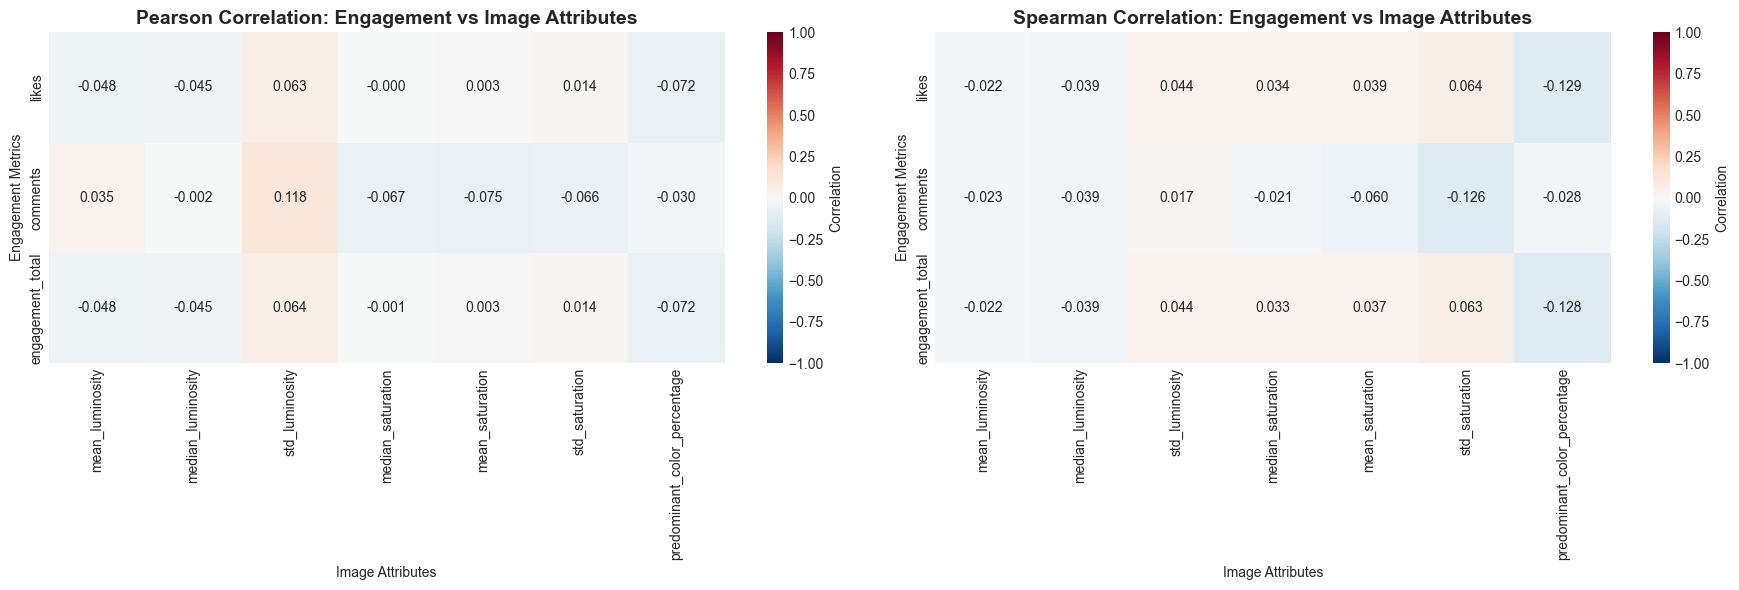


💡 Interpretation Guide:
  • Red colors = Positive correlation (both increase together)
  • Blue colors = Negative correlation (one increases, other decreases)
  • White/Light = No correlation
  • Values range from -1 (perfect negative) to +1 (perfect positive)


In [37]:
if "likes" in df.columns:
    # Create correlation heatmap
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))

    # Pearson correlation heatmap
    pearson_subset = pearson_corr.loc[engagement_vars, continuous_vars]
    sns.heatmap(
        pearson_subset,
        annot=True,
        fmt=".3f",
        cmap="RdBu_r",
        center=0,
        vmin=-1,
        vmax=1,
        ax=axes[0],
        cbar_kws={"label": "Correlation"},
    )
    axes[0].set_title(
        "Pearson Correlation: Engagement vs Image Attributes",
        fontsize=14,
        fontweight="bold",
    )
    axes[0].set_xlabel("Image Attributes")
    axes[0].set_ylabel("Engagement Metrics")

    # Spearman correlation heatmap
    spearman_subset = spearman_corr.loc[engagement_vars, continuous_vars]
    sns.heatmap(
        spearman_subset,
        annot=True,
        fmt=".3f",
        cmap="RdBu_r",
        center=0,
        vmin=-1,
        vmax=1,
        ax=axes[1],
        cbar_kws={"label": "Correlation"},
    )
    axes[1].set_title(
        "Spearman Correlation: Engagement vs Image Attributes",
        fontsize=14,
        fontweight="bold",
    )
    axes[1].set_xlabel("Image Attributes")
    axes[1].set_ylabel("Engagement Metrics")

    plt.tight_layout()
    plt.show()

    print("\n💡 Interpretation Guide:")
    print("  • Red colors = Positive correlation (both increase together)")
    print("  • Blue colors = Negative correlation (one increases, other decreases)")
    print("  • White/Light = No correlation")
    print("  • Values range from -1 (perfect negative) to +1 (perfect positive)")

### Categorical Analysis: Color Category

ENGAGEMENT BY COLOR CATEGORY
                       likes                         comments               \
                        mean            std count        mean          std   
color_category                                                               
Black           72018.000000  220155.076201    35  283.971429   304.937938   
Blue            56878.227273  141122.399996    22  214.454545   212.770551   
Cyan            30300.000000    7266.704893     5  258.800000   188.479972   
Gray            35735.120482   48162.900799    83  261.204819   429.088534   
Green           12896.333333   11405.230286     6   67.500000    39.702645   
Magenta          6174.000000    3158.204712     3   77.666667    29.365513   
Orange          36256.650000   49293.980570    60  442.483333  1511.168641   
Pink            22553.500000   17160.372442     4   83.500000    48.761323   
Purple           3445.000000            NaN     1   53.000000          NaN   
Red             60576.730769  11345

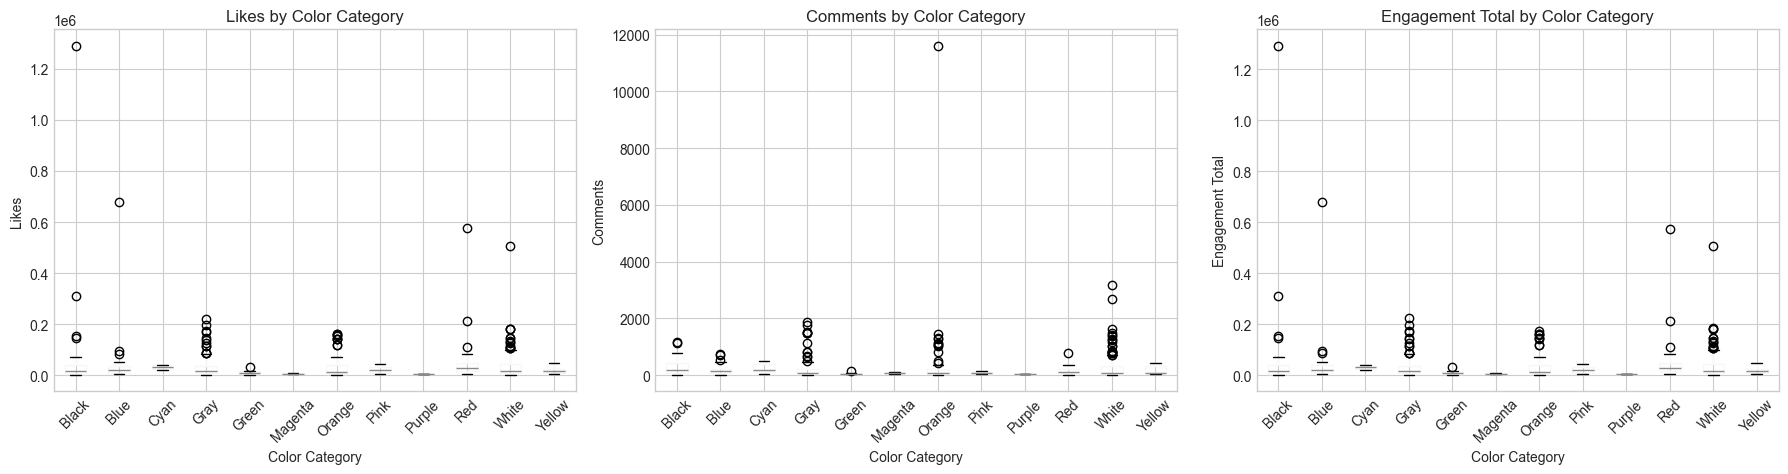

In [38]:
if "likes" in df.columns and "color_category" in df.columns:
    # Group engagement by color category
    color_engagement = df.groupby("color_category")[engagement_vars].agg(
        ["mean", "std", "count"]
    )

    print("=" * 70)
    print("ENGAGEMENT BY COLOR CATEGORY")
    print("=" * 70)
    print(color_engagement)

    # Perform Kruskal-Wallis test (non-parametric ANOVA)
    print("\n" + "=" * 70)
    print("STATISTICAL TESTS: Do different colors have different engagement?")
    print("=" * 70)

    for metric in engagement_vars:
        groups = [group[metric].values for name, group in df.groupby("color_category")]
        # Filter out groups with too few samples
        groups = [g for g in groups if len(g) >= 2]

        if len(groups) >= 2:
            h_stat, p_value = stats.kruskal(*groups)
            result = "YES ✓" if p_value < 0.05 else "No ✗"
            print(f"\n{metric.upper()}:")
            print(f"  Kruskal-Wallis H-statistic: {h_stat:.4f}")
            print(f"  P-value: {p_value:.4f}")
            print(f"  Significant difference? {result} (p<0.05)")

    # Visualize
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    for idx, metric in enumerate(engagement_vars):
        df.boxplot(column=metric, by="color_category", ax=axes[idx])
        axes[idx].set_title(f"{metric.replace('_', ' ').title()} by Color Category")
        axes[idx].set_xlabel("Color Category")
        axes[idx].set_ylabel(metric.replace("_", " ").title())
        axes[idx].tick_params(axis="x", rotation=45)

    plt.suptitle("")  # Remove default title
    plt.tight_layout()
    plt.show()

### Categorical Analysis: Color Temperature (Warm vs Cool)

ENGAGEMENT BY COLOR TEMPERATURE
                          likes                         comments              \
                           mean            std count        mean         std   
color_temperature                                                              
cool               57275.454545  140815.541802    22  213.454545  212.687055   
warm               40423.967391   87720.462752   368  292.008152  715.079415   

                        engagement_total                       
                  count             mean            std count  
color_temperature                                              
cool                 22     57488.909091  140939.448347    22  
warm                368     40715.975543   87937.606791   368  

STATISTICAL TESTS: Warm vs Cool colors

LIKES:
  Warm colors mean: 40423.97
  Cool colors mean: 57275.45
  Higher engagement: COOL
  Mann-Whitney U: nan
  P-value: nan
  Significant difference? No ✗ (p<0.05)

COMMENTS:
  Warm colors mean: 292.01


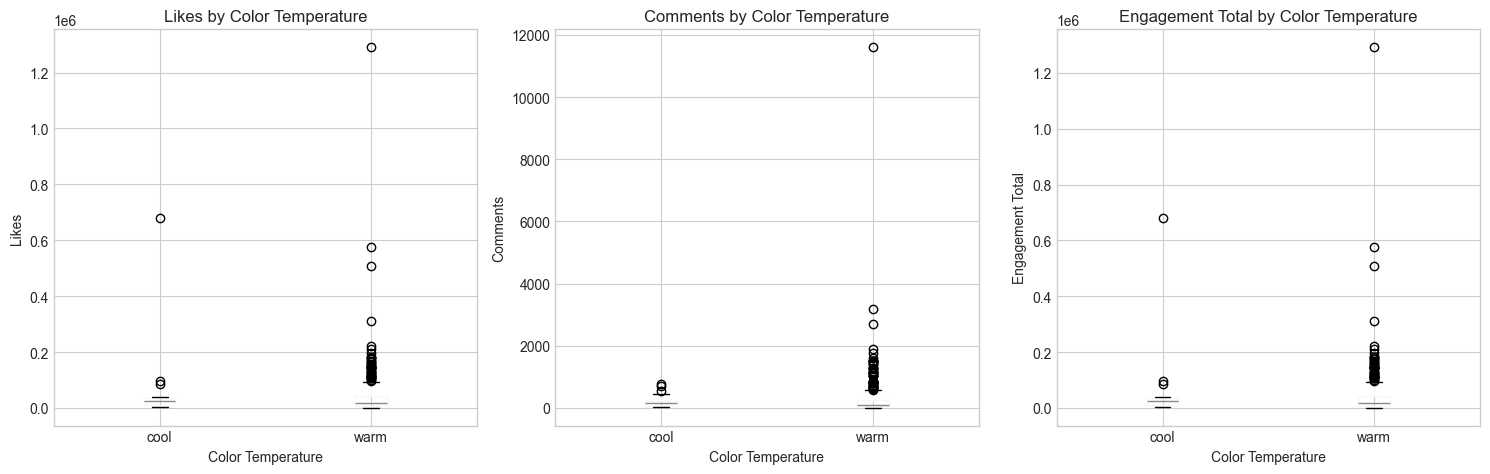

In [39]:
if "likes" in df.columns and "color_temperature" in df.columns:
    # Group engagement by color temperature
    temp_engagement = df.groupby("color_temperature")[engagement_vars].agg(
        ["mean", "std", "count"]
    )

    print("=" * 70)
    print("ENGAGEMENT BY COLOR TEMPERATURE")
    print("=" * 70)
    print(temp_engagement)

    # Perform Mann-Whitney U test (for two groups)
    print("\n" + "=" * 70)
    print("STATISTICAL TESTS: Warm vs Cool colors")
    print("=" * 70)

    warm_data = df[df["color_temperature"] == "warm"]
    cool_data = df[df["color_temperature"] == "cool"]

    for metric in engagement_vars:
        if len(warm_data) > 0 and len(cool_data) > 0:
            u_stat, p_value = stats.mannwhitneyu(
                warm_data[metric], cool_data[metric], alternative="two-sided"
            )
            result = "YES ✓" if p_value < 0.05 else "No ✗"

            warm_mean = warm_data[metric].mean()
            cool_mean = cool_data[metric].mean()
            higher = "WARM" if warm_mean > cool_mean else "COOL"

            print(f"\n{metric.upper()}:")
            print(f"  Warm colors mean: {warm_mean:.2f}")
            print(f"  Cool colors mean: {cool_mean:.2f}")
            print(f"  Higher engagement: {higher}")
            print(f"  Mann-Whitney U: {u_stat:.4f}")
            print(f"  P-value: {p_value:.4f}")
            print(f"  Significant difference? {result} (p<0.05)")

    # Visualize
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    for idx, metric in enumerate(engagement_vars):
        df.boxplot(column=metric, by="color_temperature", ax=axes[idx])
        axes[idx].set_title(f"{metric.replace('_', ' ').title()} by Color Temperature")
        axes[idx].set_xlabel("Color Temperature")
        axes[idx].set_ylabel(metric.replace("_", " ").title())

    plt.suptitle("")  # Remove default title
    plt.tight_layout()
    plt.show()

### Top Correlations Visualization

TOP CORRELATIONS - SCATTER PLOTS

Top 3 attributes correlated with LIKES:
  1. predominant_color_percentage: -0.072
  2. std_luminosity: +0.063
  3. mean_luminosity: -0.048


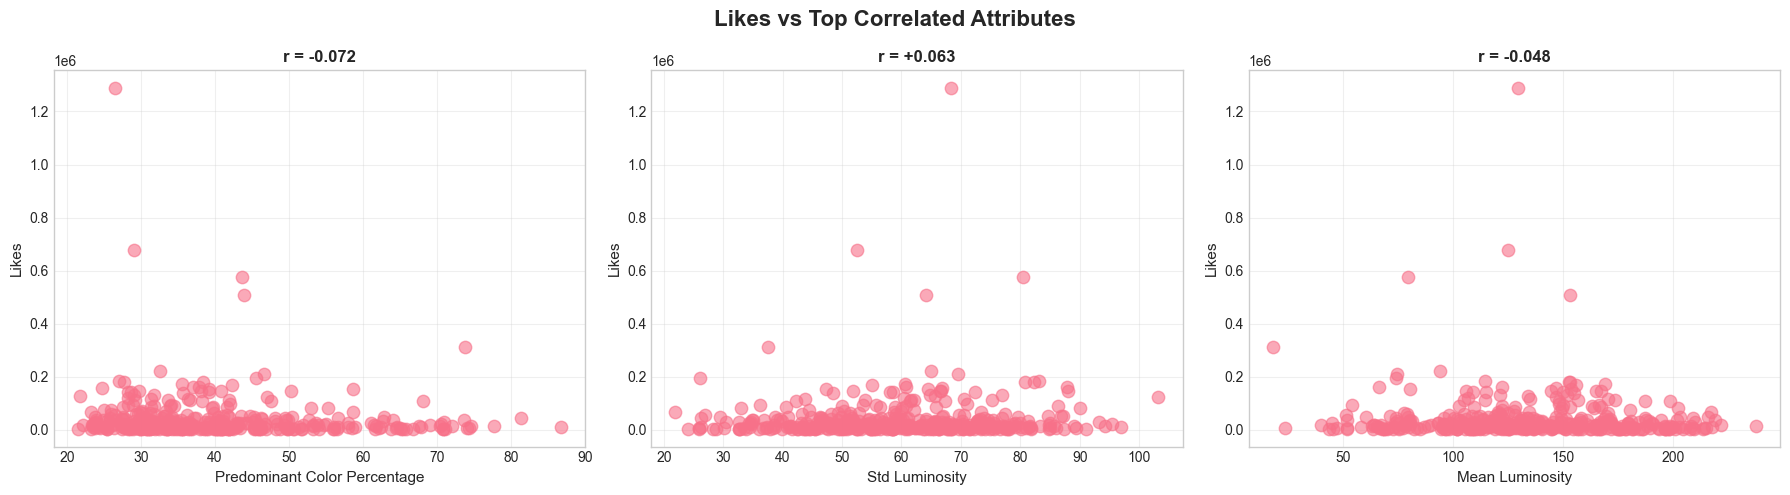


Top 3 attributes correlated with COMMENTS:
  1. std_luminosity: +0.118
  2. mean_saturation: -0.075
  3. median_saturation: -0.067


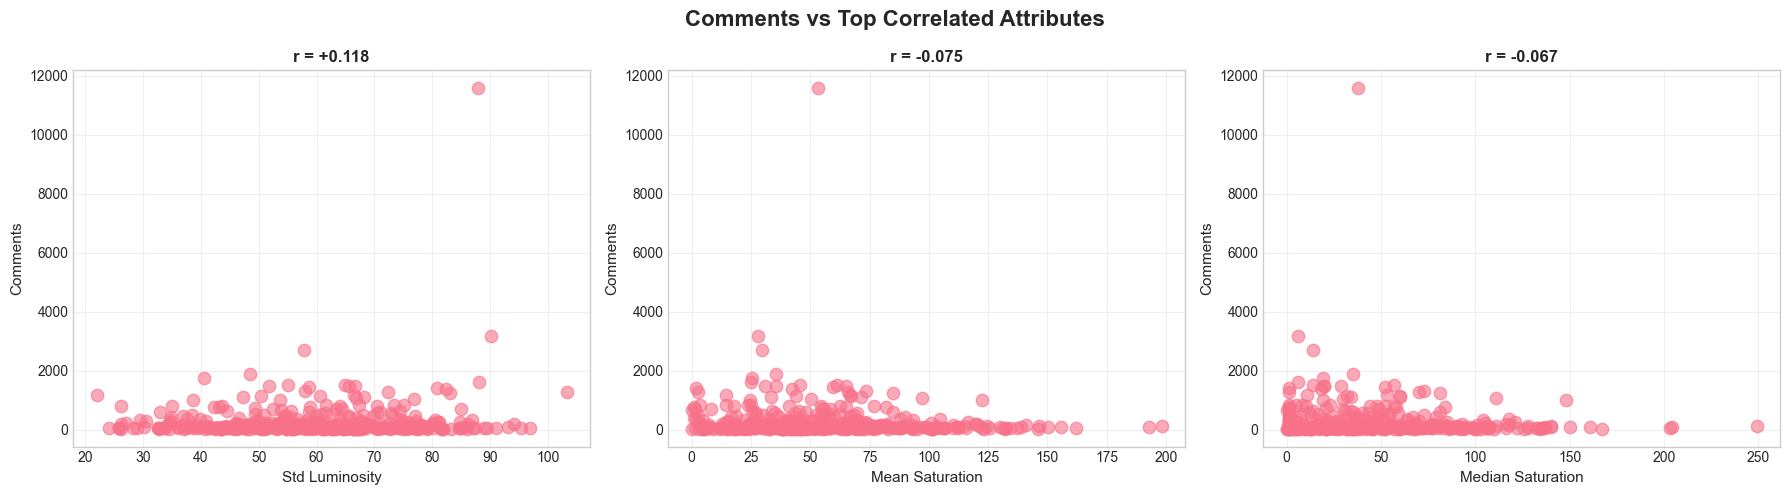


Top 3 attributes correlated with ENGAGEMENT_TOTAL:
  1. predominant_color_percentage: -0.072
  2. std_luminosity: +0.064
  3. mean_luminosity: -0.048


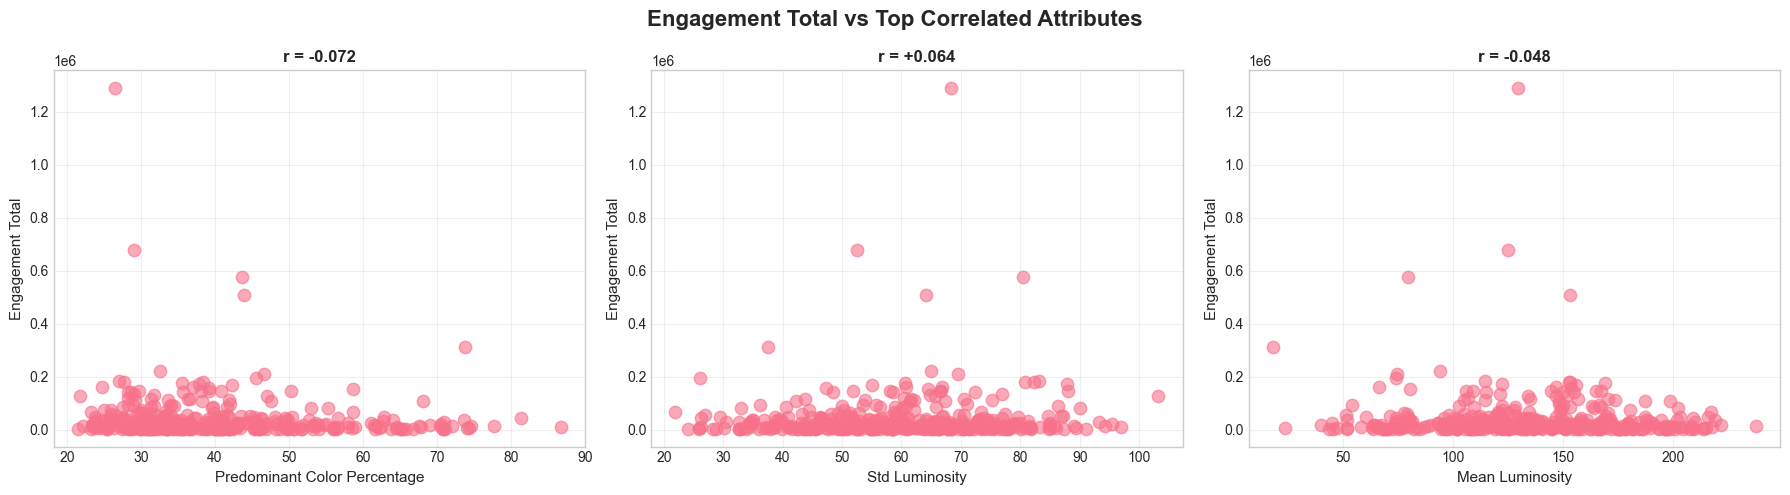

In [40]:
if "likes" in df.columns:
    # Find top 3 absolute correlations for each engagement metric
    print("=" * 70)
    print("TOP CORRELATIONS - SCATTER PLOTS")
    print("=" * 70)

    for metric in engagement_vars:
        # Get absolute correlations
        abs_corr = (
            pearson_corr[metric][continuous_vars].abs().sort_values(ascending=False)
        )
        top_3 = abs_corr.head(3).index.tolist()

        print(f"\nTop 3 attributes correlated with {metric.upper()}:")
        for i, var in enumerate(top_3, 1):
            corr_val = pearson_corr[metric][var]
            print(f"  {i}. {var}: {corr_val:+.3f}")

        # Create scatter plots
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        fig.suptitle(
            f"{metric.replace('_', ' ').title()} vs Top Correlated Attributes",
            fontsize=16,
            fontweight="bold",
        )

        for idx, var in enumerate(top_3):
            axes[idx].scatter(df[var], df[metric], alpha=0.6, s=80)

            # Add trend line
            z = np.polyfit(df[var].dropna(), df[metric][df[var].notna()], 1)
            p = np.poly1d(z)
            x_trend = np.linspace(df[var].min(), df[var].max(), 100)
            axes[idx].plot(x_trend, p(x_trend), "r--", alpha=0.8, linewidth=2)

            # Labels
            corr_val = pearson_corr[metric][var]
            axes[idx].set_xlabel(var.replace("_", " ").title(), fontsize=11)
            axes[idx].set_ylabel(metric.replace("_", " ").title(), fontsize=11)
            axes[idx].set_title(f"r = {corr_val:+.3f}", fontsize=12, fontweight="bold")
            axes[idx].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

### Summary of Key Findings

In [41]:
if "likes" in df.columns:
    print("=" * 70)
    print("KEY FINDINGS SUMMARY")
    print("=" * 70)

    # Find strongest correlations
    print("\n🔍 STRONGEST CORRELATIONS (Pearson):")
    print("-" * 70)

    for metric in engagement_vars:
        abs_corr = (
            pearson_corr[metric][continuous_vars].abs().sort_values(ascending=False)
        )
        strongest = abs_corr.index[0]
        strongest_val = pearson_corr[metric][strongest]

        direction = "positive" if strongest_val > 0 else "negative"
        print(f"\n{metric.upper()}:")
        print(f"  Strongest correlation: {strongest}")
        print(f"  Correlation value: {strongest_val:+.3f} ({direction})")

        if abs(strongest_val) >= 0.5:
            print(f"  Interpretation: STRONG relationship")
        elif abs(strongest_val) >= 0.3:
            print(f"  Interpretation: MODERATE relationship")
        else:
            print(f"  Interpretation: WEAK relationship")

    # Color preferences
    print("\n\n🎨 COLOR PREFERENCES:")
    print("-" * 70)

    if "color_category" in df.columns:
        for metric in engagement_vars:
            top_color = df.groupby("color_category")[metric].mean().idxmax()
            top_value = df.groupby("color_category")[metric].mean().max()
            print(f"\n{metric.upper()}:")
            print(f"  Best performing color: {top_color}")
            print(f"  Average {metric}: {top_value:.2f}")

    if "color_temperature" in df.columns:
        print("\n\n🌡️ COLOR TEMPERATURE PREFERENCES:")
        print("-" * 70)
        for metric in engagement_vars:
            warm_mean = df[df["color_temperature"] == "warm"][metric].mean()
            cool_mean = df[df["color_temperature"] == "cool"][metric].mean()
            preferred = "WARM" if warm_mean > cool_mean else "COOL"
            diff_pct = abs((warm_mean - cool_mean) / max(warm_mean, cool_mean) * 100)

            print(f"\n{metric.upper()}:")
            print(f"  Warm colors: {warm_mean:.2f}")
            print(f"  Cool colors: {cool_mean:.2f}")
            print(f"  Preferred: {preferred} colors ({diff_pct:.1f}% higher)")

    print("\n" + "=" * 70)

KEY FINDINGS SUMMARY

🔍 STRONGEST CORRELATIONS (Pearson):
----------------------------------------------------------------------

LIKES:
  Strongest correlation: predominant_color_percentage
  Correlation value: -0.072 (negative)
  Interpretation: WEAK relationship

COMMENTS:
  Strongest correlation: std_luminosity
  Correlation value: +0.118 (positive)
  Interpretation: WEAK relationship

ENGAGEMENT_TOTAL:
  Strongest correlation: predominant_color_percentage
  Correlation value: -0.072 (negative)
  Interpretation: WEAK relationship


🎨 COLOR PREFERENCES:
----------------------------------------------------------------------

LIKES:
  Best performing color: Black
  Average likes: 72018.00

COMMENTS:
  Best performing color: Orange
  Average comments: 442.48

ENGAGEMENT_TOTAL:
  Best performing color: Black
  Average engagement_total: 72301.97


🌡️ COLOR TEMPERATURE PREFERENCES:
----------------------------------------------------------------------

LIKES:
  Warm colors: 40423.97
  Coo